In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
os.chdir(r"C:\Users\TOMLU\Desktop\Data3888\individual")

In [3]:
CENTERED_DIR = os.path.join("projectdata", "images", "100_stratified4fold_1000per_seed3888")
UNCENTERED_DIR = os.path.join("projectdata", "images", "uncentred_ternary_224_stratified4fold_1000per_seed3888")
BIG_IMAGE_PATH = os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5  
SEED = 3888
DESIRED_IMAGE_SIZE = 100
BATCH_SIZE = 32
NUM_CLASSES = 3
TILE_SIZE = 224                     
STRIDE = 224 
CLASS_NAMES = ['Empty', 'Non-tumor', 'Tumor']
QUADRANTS = ['Q1', 'Q2', 'Q3', 'Q4']

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

In [5]:
# Custom dataset to load image and corresponding label
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img), self.labels[idx]

# Load images and labels from Q folders (e.g. Q1, Q2, Q3)
def load_quadrant_data(base_dir, quadrants):
    paths, labels = [], []
    for q in quadrants:
        for class_idx, class_name in enumerate(CLASS_NAMES):
            folder = os.path.join(base_dir, q, class_name)
            files = glob(os.path.join(folder, '*.png'))
            paths.extend(files)
            labels.extend([class_idx] * len(files))
    return paths, labels

# Create VGG16 model with last layer adapted to our 3-class classification
from torchvision.models import vgg16, VGG16_Weights

def get_vgg16_model(num_classes):
    weights = VGG16_Weights.DEFAULT
    model = vgg16(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model



In [6]:
from tqdm import tqdm  

def train_model(model, train_loader, val_loader, device, fold_id=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    model = model.to(device)

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    # Plotting Accuracy and Loss
    epochs_range = range(EPOCHS)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(epochs_range, train_accuracies, label='Train Acc')
    axs[0].plot(epochs_range, val_accuracies, label='Val Acc')
    axs[0].set_title(f'Fold {fold_id}: Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs_range, train_losses, label='Train Loss')
    axs[1].plot(epochs_range, val_losses, label='Val Loss')
    axs[1].set_title(f'Fold {fold_id}: Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model



 Fold 1: Train on ['Q1', 'Q2', 'Q3'], Validate on Q4
Loading training and validation image paths...
Loaded 3143 training images, 1103 validation images.
Building datasets and dataloaders...
DataLoaders ready.
Initializing model...
Starting training...
Epoch 1/5


Training Epoch 1: 100%|██████████| 99/99 [04:32<00:00,  2.75s/it]


Epoch 1: Train Acc=0.7731, Val Acc=0.7797, Train Loss=0.4895, Val Loss=0.6027
Epoch 2/5


Training Epoch 2: 100%|██████████| 99/99 [04:23<00:00,  2.66s/it]


Epoch 2: Train Acc=0.8361, Val Acc=0.8051, Train Loss=0.3521, Val Loss=0.5830
Epoch 3/5


Training Epoch 3: 100%|██████████| 99/99 [04:22<00:00,  2.66s/it]


Epoch 3: Train Acc=0.8855, Val Acc=0.8051, Train Loss=0.2637, Val Loss=0.6278
Epoch 4/5


Training Epoch 4: 100%|██████████| 99/99 [04:22<00:00,  2.65s/it]


Epoch 4: Train Acc=0.9240, Val Acc=0.7842, Train Loss=0.1767, Val Loss=0.9148
Epoch 5/5


Training Epoch 5: 100%|██████████| 99/99 [04:22<00:00,  2.65s/it]


Epoch 5: Train Acc=0.9542, Val Acc=0.7688, Train Loss=0.1221, Val Loss=1.3574


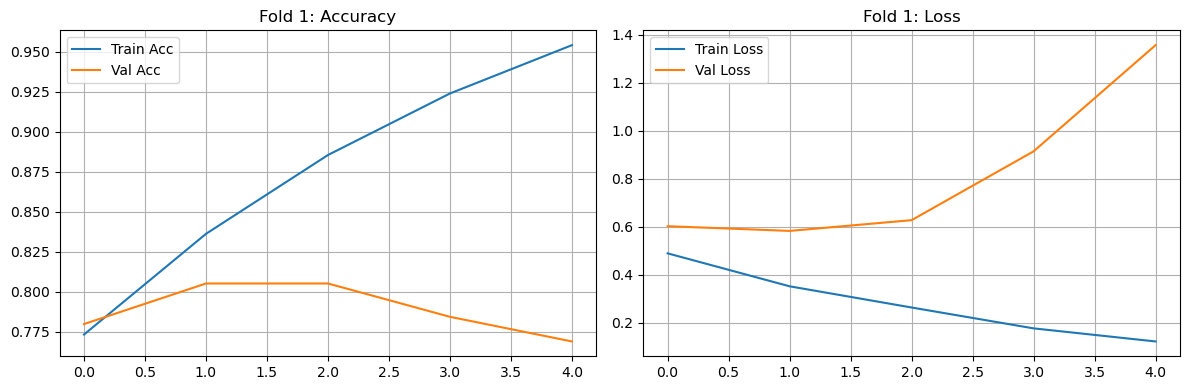

Evaluating model on validation set...
Fold 1 Results → Acc: 0.7688, Prec: 0.8015, Recall: 0.8303, F1: 0.8049
Final model saved as 'trained_model_VGG16.pth'

 Fold 2: Train on ['Q1', 'Q2', 'Q4'], Validate on Q3
Loading training and validation image paths...
Loaded 3143 training images, 1103 validation images.
Building datasets and dataloaders...
DataLoaders ready.
Initializing model...
Starting training...
Epoch 1/5


Training Epoch 1: 100%|██████████| 99/99 [04:28<00:00,  2.71s/it]


Epoch 1: Train Acc=0.7878, Val Acc=0.7670, Train Loss=0.4750, Val Loss=0.4939
Epoch 2/5


Training Epoch 2: 100%|██████████| 99/99 [04:26<00:00,  2.69s/it]


Epoch 2: Train Acc=0.8606, Val Acc=0.6428, Train Loss=0.3397, Val Loss=0.8881
Epoch 3/5


Training Epoch 3: 100%|██████████| 99/99 [04:29<00:00,  2.72s/it]


Epoch 3: Train Acc=0.9036, Val Acc=0.7616, Train Loss=0.2486, Val Loss=0.5181
Epoch 4/5


Training Epoch 4: 100%|██████████| 99/99 [04:27<00:00,  2.70s/it]


Epoch 4: Train Acc=0.9300, Val Acc=0.7325, Train Loss=0.1843, Val Loss=0.6782
Epoch 5/5


Training Epoch 5: 100%|██████████| 99/99 [04:27<00:00,  2.70s/it]


Epoch 5: Train Acc=0.9625, Val Acc=0.7389, Train Loss=0.1112, Val Loss=0.7484


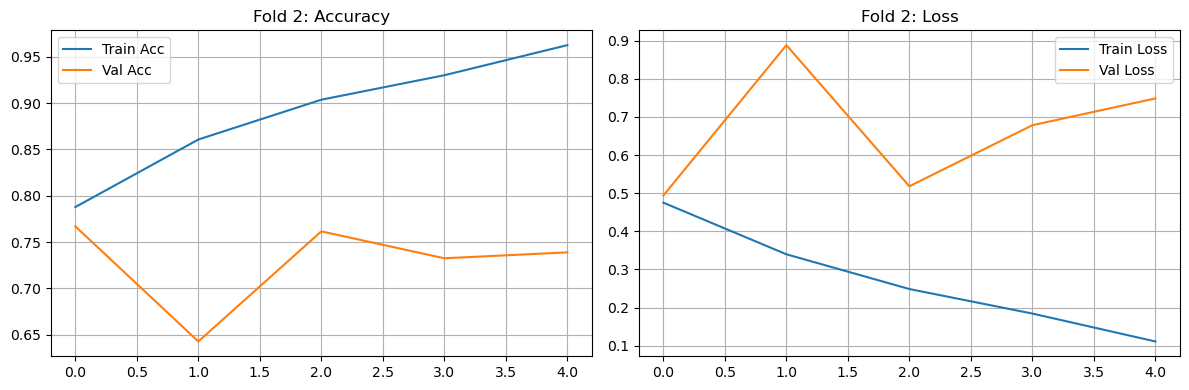

Evaluating model on validation set...
Fold 2 Results → Acc: 0.7389, Prec: 0.8058, Recall: 0.8086, F1: 0.8071

 Fold 3: Train on ['Q1', 'Q3', 'Q4'], Validate on Q2
Loading training and validation image paths...
Loaded 3256 training images, 990 validation images.
Building datasets and dataloaders...
DataLoaders ready.
Initializing model...
Starting training...
Epoch 1/5


Training Epoch 1: 100%|██████████| 102/102 [04:42<00:00,  2.77s/it]


Epoch 1: Train Acc=0.7568, Val Acc=0.8232, Train Loss=0.5113, Val Loss=0.4010
Epoch 2/5


Training Epoch 2: 100%|██████████| 102/102 [04:40<00:00,  2.75s/it]


Epoch 2: Train Acc=0.8329, Val Acc=0.8394, Train Loss=0.3866, Val Loss=0.4239
Epoch 3/5


Training Epoch 3: 100%|██████████| 102/102 [04:37<00:00,  2.72s/it]


Epoch 3: Train Acc=0.8842, Val Acc=0.8232, Train Loss=0.2942, Val Loss=0.4879
Epoch 4/5


Training Epoch 4: 100%|██████████| 102/102 [04:36<00:00,  2.71s/it]


Epoch 4: Train Acc=0.9205, Val Acc=0.7909, Train Loss=0.1937, Val Loss=0.6357
Epoch 5/5


Training Epoch 5: 100%|██████████| 102/102 [04:38<00:00,  2.73s/it]


Epoch 5: Train Acc=0.9536, Val Acc=0.8162, Train Loss=0.1257, Val Loss=0.6256


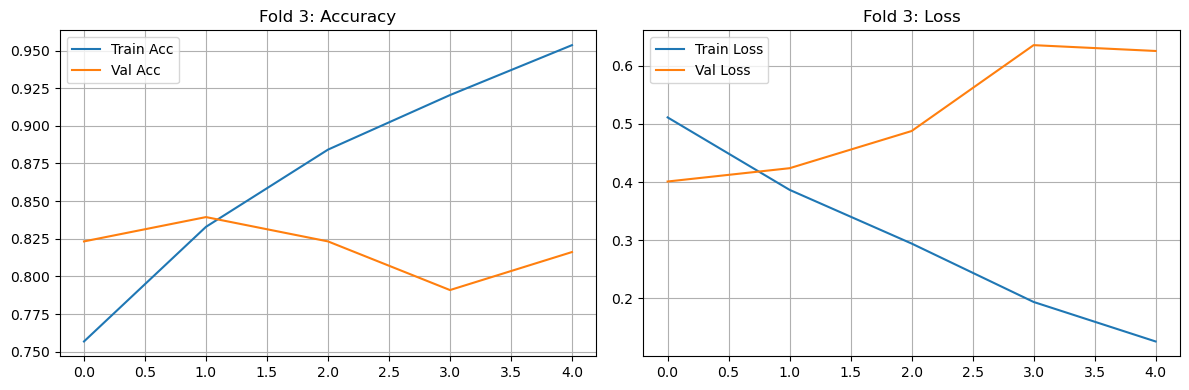

Evaluating model on validation set...
Fold 3 Results → Acc: 0.8162, Prec: 0.8616, Recall: 0.8586, F1: 0.8601

 Fold 4: Train on ['Q2', 'Q3', 'Q4'], Validate on Q1
Loading training and validation image paths...
Loaded 3196 training images, 1050 validation images.
Building datasets and dataloaders...
DataLoaders ready.
Initializing model...
Starting training...
Epoch 1/5


Training Epoch 1: 100%|██████████| 100/100 [04:31<00:00,  2.72s/it]


Epoch 1: Train Acc=0.7794, Val Acc=0.7971, Train Loss=0.4853, Val Loss=0.4463
Epoch 2/5


Training Epoch 2: 100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


Epoch 2: Train Acc=0.8479, Val Acc=0.7933, Train Loss=0.3570, Val Loss=0.4971
Epoch 3/5


Training Epoch 3: 100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


Epoch 3: Train Acc=0.8955, Val Acc=0.7752, Train Loss=0.2574, Val Loss=0.5829
Epoch 4/5


Training Epoch 4: 100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


Epoch 4: Train Acc=0.9299, Val Acc=0.7657, Train Loss=0.1820, Val Loss=0.7408
Epoch 5/5


Training Epoch 5: 100%|██████████| 100/100 [04:30<00:00,  2.71s/it]


Epoch 5: Train Acc=0.9487, Val Acc=0.7810, Train Loss=0.1358, Val Loss=0.8129


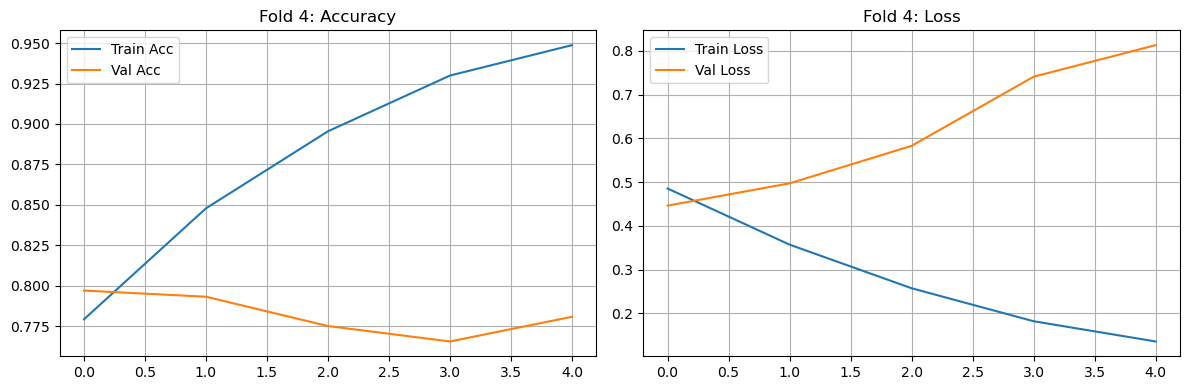

Evaluating model on validation set...
Fold 4 Results → Acc: 0.7810, Prec: 0.8383, Recall: 0.8388, F1: 0.8383


In [18]:
from itertools import combinations

# Define fixed folds using each Q as validation once
folds = [
    (['Q1', 'Q2', 'Q3'], 'Q4'),
    (['Q1', 'Q2', 'Q4'], 'Q3'),
    (['Q1', 'Q3', 'Q4'], 'Q2'),
    (['Q2', 'Q3', 'Q4'], 'Q1'),
]

cv_results = []

for i, (train_quads, val_quad) in enumerate(folds):
    print(f"\n Fold {i+1}: Train on {train_quads}, Validate on {val_quad}")

    print("Loading training and validation image paths...")
    train_paths, train_labels = load_quadrant_data(CENTERED_DIR, train_quads)
    val_paths, val_labels = load_quadrant_data(CENTERED_DIR, [val_quad])
    print(f"Loaded {len(train_paths)} training images, {len(val_paths)} validation images.")

    print("Building datasets and dataloaders...")
    train_dataset = CustomImageDataset(train_paths, train_labels, transform)
    val_dataset = CustomImageDataset(val_paths, val_labels, transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    print("DataLoaders ready.")

    print("Initializing model...")
    model = get_vgg16_model(num_classes=len(CLASS_NAMES))
    print("Starting training...")
    model = train_model(model, train_loader, val_loader, device, fold_id=i+1)
    
    print("Evaluating model on validation set...")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Record metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Fold {i+1} Results → Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    cv_results.append({'fold': i+1, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})
    
    if i == 0:
        torch.save(model.state_dict(), "trained_model_VGG16.pth")
        print("Final model saved as 'trained_model_VGG16.pth'")


In [20]:
# Summarize and display cross-validation results
cv_df = pd.DataFrame(cv_results)

print("\nCross-Validation Results per Fold:")
print(cv_df)

print("\nCross-Validation Averages:")
print(cv_df.mean(numeric_only=True))


Cross-Validation Results per Fold:
   fold  accuracy  precision    recall        f1
0     1  0.768812   0.801450  0.830262  0.804926
1     2  0.738894   0.805777  0.808588  0.807148
2     3  0.816162   0.861554  0.858644  0.860089
3     4  0.780952   0.838259  0.838781  0.838338

Cross-Validation Averages:
fold         2.500000
accuracy     0.776205
precision    0.826760
recall       0.834069
f1           0.827625
dtype: float64


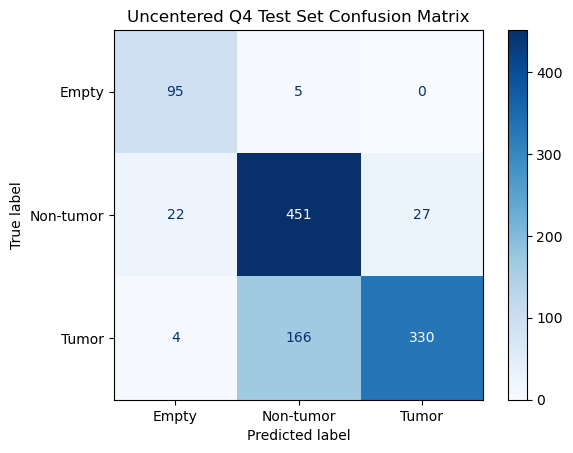


🧪 Final Test Set Metrics (Uncentered Q4):
Accuracy: 0.7963636363636364
Precision: 0.8115247002311329
Recall: 0.8373333333333334
F1 Score: 0.8112594767135229


In [21]:
# Load uncentered Q4 data for final test
test_paths, test_labels = load_quadrant_data(UNCENTERED_DIR, ['Q4'])
test_dataset = CustomImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Use the last trained model for testing
model.eval()
preds, trues = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        trues.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(trues, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES).plot(cmap='Blues')
plt.title('Uncentered Q4 Test Set Confusion Matrix')
plt.show()

# Print test metrics
print("\n🧪 Final Test Set Metrics (Uncentered Q4):")
print("Accuracy:", accuracy_score(trues, preds))
print("Precision:", precision_score(trues, preds, average='macro', zero_division=0))
print("Recall:", recall_score(trues, preds, average='macro', zero_division=0))
print("F1 Score:", f1_score(trues, preds, average='macro', zero_division=0))


In [6]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm


model = get_vgg16_model(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("trained_model_VGG16.pth", map_location=DEVICE))
model.eval()


Image.MAX_IMAGE_PIXELS = None
big_img = Image.open(BIG_IMAGE_PATH)
width, height = big_img.size
print(f"Full image size: {width} x {height}")


n_rows = (height - TILE_SIZE) // STRIDE + 1
n_cols = (width - TILE_SIZE) // STRIDE + 1
print(f"Tiles: {n_rows} rows x {n_cols} cols")


def preprocess_tile(tile):
    tile = tile.resize((TILE_SIZE, TILE_SIZE))                    # Resize to model input
    tile = np.array(tile) / 255.0                                 # Normalize to [0, 1]
    tile = torch.tensor(tile, dtype=torch.float32).permute(2, 0, 1)  
    return tile.unsqueeze(0) 



tumor_tile_count = 0
total_tiles = 0


with tqdm(total=n_rows * n_cols, desc="Predicting on full image") as pbar:
    for i in range(n_rows):
        for j in range(n_cols):
            left = j * STRIDE
            upper = i * STRIDE
            right = left + TILE_SIZE
            lower = upper + TILE_SIZE

            try:
                tile = big_img.crop((left, upper, right, lower)).copy()
            except Exception as e:
                print(f"Skipping tile at ({left},{upper}) due to crop error: {e}")
                pbar.update(1)
                continue

            tile_tensor = preprocess_tile(tile).to(DEVICE)

            with torch.no_grad():
                output = model(tile_tensor)                     # raw logits
                probs = F.softmax(output, dim=1)[0]             # softmax vector
                pred_class = torch.argmax(probs).item()         

                
                region_label = 1 if pred_class == 0 else 0
                tumor_tile_count += region_label
                total_tiles += 1

            pbar.update(1)


if total_tiles > 0:
    tumor_ratio = tumor_tile_count / total_tiles * 100
    print(f"\nTiles predicted as Tumor: {tumor_tile_count}/{total_tiles}")
    print(f"Tumor Ratio in Full Image: {tumor_ratio:.2f}%")
else:
    print("No valid tiles processed.")

Full image size: 30786 x 24241
Tiles: 108 rows x 137 cols


Predicting on full image: 100%|██████████| 14796/14796 [18:08<00:00, 13.60it/s]


Tiles predicted as Tumor: 5040/14796
Tumor Ratio in Full Image: 34.06%


Image size: 30786 x 24241, Tiles: 108 rows x 137 cols


Predicting: 100%|██████████| 232/232 [15:24<00:00,  3.98s/it]


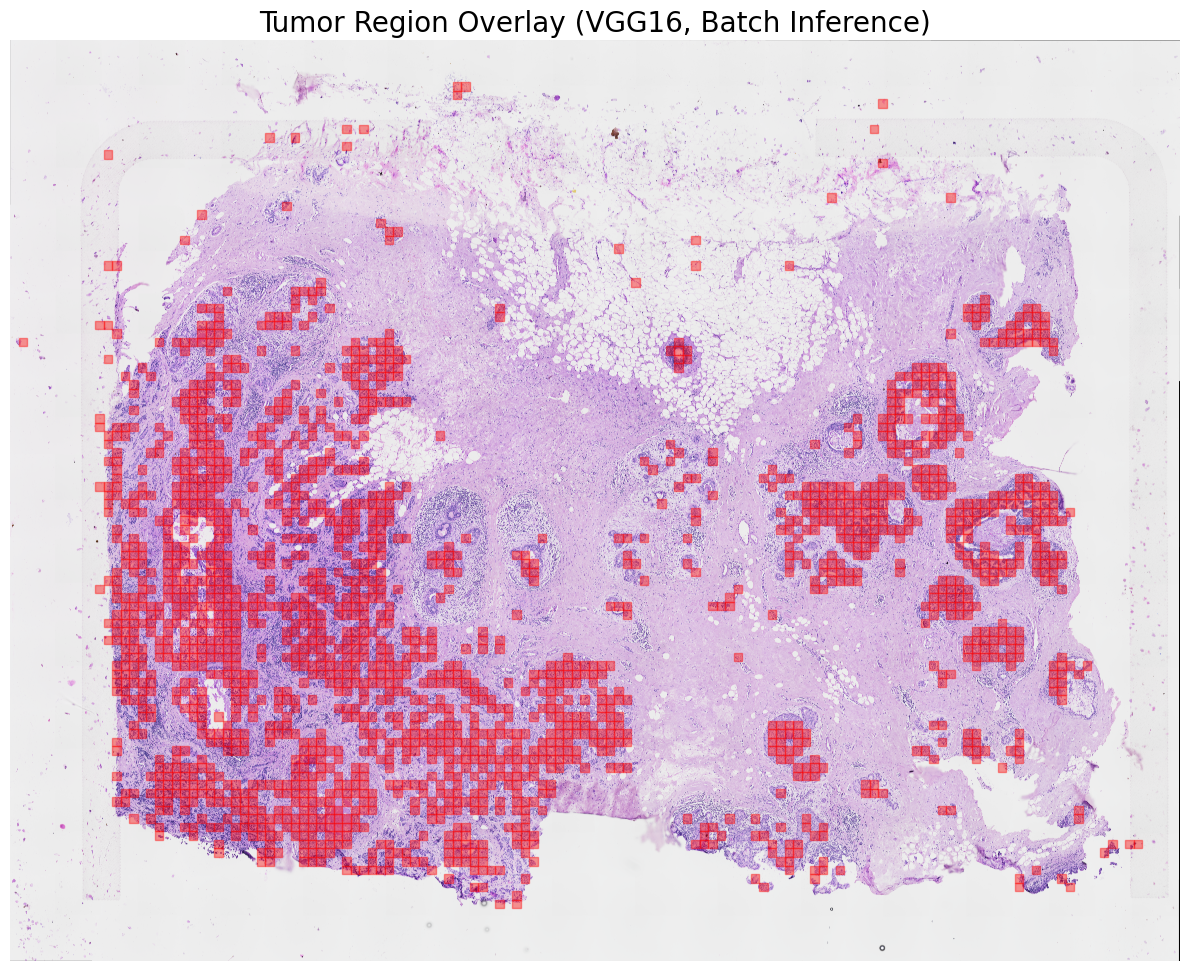

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm

# ==== CONFIG ====
stride = 224
TILE_SIZE = 224
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BIG_IMAGE_PATH = os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif")

# ==== Step 1: Load big image and compute grid ====
big_img = Image.open(BIG_IMAGE_PATH).convert("RGB")
img_width, img_height = big_img.size

n_cols = img_width // stride
n_rows = img_height // stride
print(f"Image size: {img_width} x {img_height}, Tiles: {n_rows} rows x {n_cols} cols")

# ==== Step 2: Extract tiles ====
tiles = []
positions = []

for i in range(n_rows):
    for j in range(n_cols):
        left = j * stride
        upper = i * stride
        right = left + TILE_SIZE
        lower = upper + TILE_SIZE

        tile = big_img.crop((left, upper, right, lower))
        tile_np = np.array(tile) / 255.0  # normalize
        tile_tensor = torch.tensor(tile_np, dtype=torch.float32).permute(2, 0, 1)
        tiles.append(tile_tensor)
        positions.append((i, j))  # record position for reconstruction

# ==== Step 3: Load model ====
model = get_vgg16_model(num_classes=3).to(DEVICE)
model.load_state_dict(torch.load("trained_model_VGG16.pth", map_location=DEVICE))
model.eval()

# ==== Step 4: Run inference in batches ====
pred_classes = []

with torch.no_grad():
    for i in tqdm(range(0, len(tiles), BATCH_SIZE), desc="Predicting"):
        batch = tiles[i:i + BATCH_SIZE]
        batch_tensor = torch.stack(batch).to(DEVICE)
        outputs = model(batch_tensor)
        probs = F.softmax(outputs, dim=1)
        batch_preds = torch.argmax(probs, dim=1).cpu().numpy()
        pred_classes.extend(batch_preds)

pred_classes = np.array(pred_classes)

# ==== Step 5: Create visualization ====
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(big_img)

for idx, (i, j) in enumerate(positions):
    if pred_classes[idx] == 2:  # Tumor class index
        rect = patches.Rectangle(
            (j * stride, i * stride),
            TILE_SIZE, TILE_SIZE,
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.4
        )
        ax.add_patch(rect)

plt.title("Tumor Region Overlay (VGG16, Batch Inference)", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()
